# Pre-processing

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!pip install osmnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.3/101.3 kB 2.6 MB/s eta 0:00:00


**Set random seed**

In [ ]:
# Reproducibility: set random seed
import os
import random
import numpy as np
import torch

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

In [ ]:
import osmnx as ox
# Set the global configuration of OSMnx
ox.settings.log_console = True
ox.settings.use_cache    = True
ox.settings.data_folder  = os.path.join('/content/drive/MyDrive', 'Ruian_ERP', 'osmnx_cache')
# Create the result storage directory
base_path = '/content/drive/MyDrive/Ruian_ERP/road_networks/Stockport'
os.makedirs(base_path, exist_ok=True)


In [ ]:
print("CUDA:", torch.cuda.is_available())
print("Device:", torch.cuda.get_device_name(0))

CUDA: True
Device: NVIDIA A100-SXM4-40GB


**Download and preprocess the Greater Manchester road network**

In [ ]:
import osmnx as ox
import networkx as nx
# Download the driving network for Stockport
G_full = ox.graph_from_place("Stockport, UK", network_type="drive")

# Download the graph
graph_path = os.path.join(base_path, 'Stockport_graph.graphml')

if os.path.exists(graph_path):
     # 1. If already saved, read it directly
     G = ox.load_graphml(graph_path)
else:
     # 2. Otherwise, download, process and save it
     G = ox.graph_from_place('Stockport, Greater Manchester, UK', network_type='drive')
     G = ox.project_graph(G)
     isolated = list(nx.isolates(G))
     G.remove_nodes_from(isolated)
     ox.save_graphml(G, graph_path)

# 3. Convert to GeoDataFrames
nodes_gdf, edges_gdf = ox.graph_to_gdfs(G)

# 4. Save nodes and edges to shapefile
nodes_shp = os.path.join(base_path, 'nodes.shp')
nodes_gdf.to_file(nodes_shp)
edges_shp = os.path.join(base_path, 'edges.shp')
edges_gdf.to_file(edges_shp)


/tmp/ipython-input-6-2040324823.py:25: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  nodes_gdf.to_file(nodes_shp)
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'street_count' to 'street_cou'
  ogr_write(


In [ ]:
# Check the coordinate reference system
print(nodes_gdf.crs, edges_gdf.crs)

EPSG:32630 EPSG:32630


# Feature construction

## Sanity check

      osmid             y              x            highway   ref  street_cou  \
0    234966  5.917067e+06  552000.104922  motorway_junction     3           3   
1  15311937  5.916738e+06  551766.511679               None  None           3   
2  15316374  5.916882e+06  551300.226224  motorway_junction     4           3   
3    234967  5.917188e+06  552297.726137               None  None           3   
4    334001  5.916935e+06  550799.405422  motorway_junction     1           3   

  junction railway                        geometry  
0     None    None  POINT (552000.105 5917067.017)  
1     None    None  POINT (551766.512 5916738.316)  
2     None    None  POINT (551300.226 5916881.784)  
3     None    None  POINT (552297.726 5917187.834)  
4     None    None  POINT (550799.405 5916935.263)  


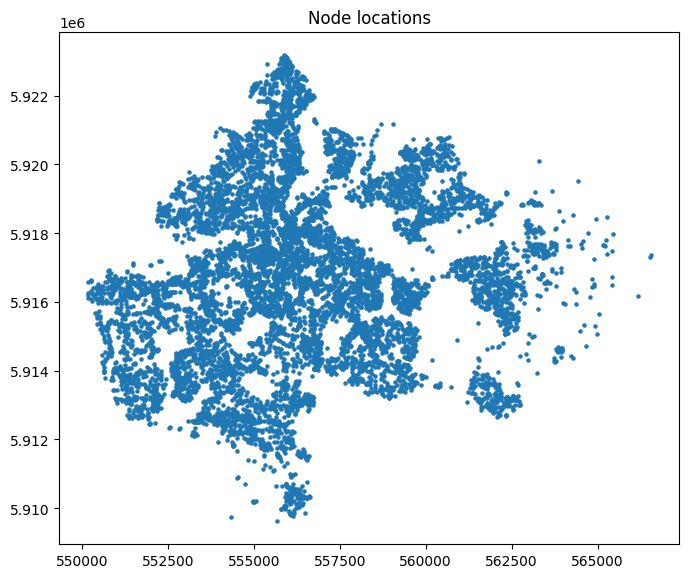

In [ ]:
import os
import geopandas as gpd
import matplotlib.pyplot as plt

# -----------------------------------------------------------------------------
# 2. Read back the saved Shapefile and inspect
# -----------------------------------------------------------------------------
shp_path = os.path.join(base_path, 'nodes.shp')
nodes = gpd.read_file(shp_path)

# print first few rows to check attributes and geometry
print(nodes.head())

# -----------------------------------------------------------------------------
# 3. Simple spatial visualization
# -----------------------------------------------------------------------------
ax = nodes.plot(figsize=(8, 8), markersize=5)
ax.set_title("Node locations")
plt.show()


          u         v  key                                      osmid  \
0    234966  15311937    0  [4966857, 30631403, 1128685924, 30631406]   
1    234966  15316374    0            [30631490, 135848931, 30631502]   
2  15311937  15311946    0                      [4972168, 1128685925]   
3  15316374  15312006    0                                    4966822   
4  15316374    334547    0                                  979363523   

         highway       lanes              maxspeed  oneway  ref reversed  \
0  motorway_link           2  ['70 mph', '40 mph']    True  M60    False   
1       motorway           4                70 mph    True  M60    False   
2  motorway_link  ['3', '2']                40 mph    True  M60    False   
3       motorway           2                70 mph    True  M56    False   
4       motorway           3                70 mph    True  M60    False   

       length bridge  name junction access tunnel width  area  \
0  439.860261   None  None     None   N

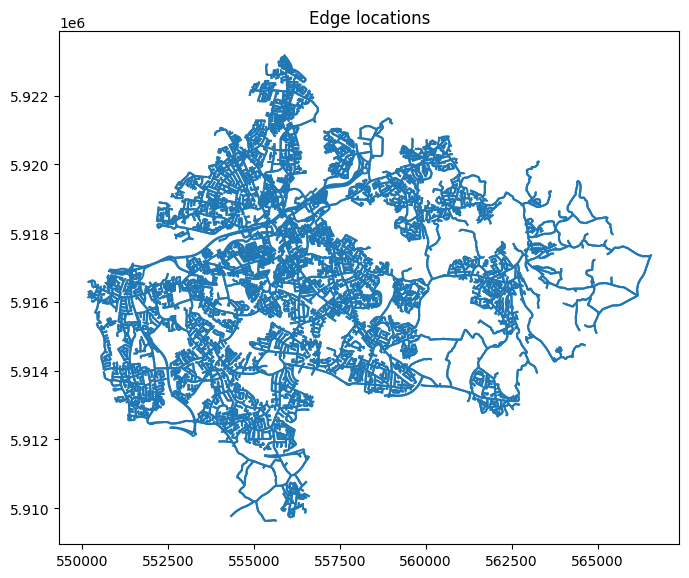

In [ ]:
shp_path = os.path.join(base_path, 'edges.shp')
edges = gpd.read_file(shp_path)

# print first few rows to check attributes and geometry
print(edges.head())

ax = edges.plot(figsize=(8, 8), markersize=5)
ax.set_title("Edge locations")
plt.show()

## Feature extraction & preprocessing

**Collect original node/edge features**

In [ ]:
import osmnx as ox
import networkx as nx
import pandas as pd
import numpy as np

# 1. Load the main image of the entire city
graphml_path = os.path.join(base_path, "Stockport_graph.graphml")
G = ox.load_graphml(graphml_path)

# 2. Convert to geoDataframes for nodes and edges
nodes_gdf, edges_gdf = ox.graph_to_gdfs(G)

# 3. Node feature DataFrame
node_records = []

for node_id, row in nodes_gdf.iterrows():
    node_records.append({
        'node': node_id,
        'x': row.geometry.x,
        'y': row.geometry.y,
        'degree': G.degree(node_id),
        #'highway': row.get('highway', 'unclassified')
    })
nodes_df = pd.DataFrame(node_records)

# 4. Edge feature DataFrame
edge_records = []
for u, v, data in G.edges(data=True):
    edge_records.append({
        'u': u, 'v': v,
        'length': data.get('length', np.nan),
        'maxspeed': data.get('maxspeed', np.nan),
        'lanes': data.get('lanes', np.nan),
        'highway': data.get('highway', 'unclassified')
    })
edges_df = pd.DataFrame(edge_records)


In [ ]:
edges_df

,u,v,length,maxspeed,lanes,highway
0,234966,15311937,439.860261,"[70 mph, 40 mph]",2,motorway_link
1,234966,15316374,723.418337,70 mph,4,motorway
2,15311937,15311946,290.487638,40 mph,"[3, 2]",motorway_link
3,15316374,15312006,447.476989,70 mph,2,motorway
4,15316374,334547,543.723844,70 mph,3,motorway
...,...,...,...,...,...,...
22405,12947145063,12947145062,10.148451,NaN,NaN,residential
22406,12947145063,12595404702,94.040217,NaN,NaN,residential
22407,12947145063,12962058683,40.867844,NaN,NaN,residential
22408,12947145062,12947145063,10.148451,NaN,NaN,residential


In [ ]:
nodes_df

,node,x,y,degree
0,234966,552000.104922,5.917067e+06,3
1,15311937,551766.511679,5.916738e+06,2
2,15316374,551300.226224,5.916882e+06,3
3,234967,552297.726137,5.917188e+06,3
4,334001,550799.405422,5.916935e+06,2
...,...,...,...,...
9967,12595404703,556172.154438,5.909859e+06,6
9968,12595404702,556147.490210,5.909864e+06,6
9969,12947145063,556060.048640,5.909841e+06,6
9970,12947145062,556050.174652,5.909838e+06,2




---

### Edges operations:

In [ ]:
edges_df

,u,v,length,maxspeed,lanes,highway
0,234966,15311937,439.860261,"[70 mph, 40 mph]",2,motorway_link
1,234966,15316374,723.418337,70 mph,4,motorway
2,15311937,15311946,290.487638,40 mph,"[3, 2]",motorway_link
3,15316374,15312006,447.476989,70 mph,2,motorway
4,15316374,334547,543.723844,70 mph,3,motorway
...,...,...,...,...,...,...
22405,12947145063,12947145062,10.148451,NaN,NaN,residential
22406,12947145063,12595404702,94.040217,NaN,NaN,residential
22407,12947145063,12962058683,40.867844,NaN,NaN,residential
22408,12947145062,12947145063,10.148451,NaN,NaN,residential


In [ ]:
import os
import re
import ast
import numpy as np
import pandas as pd
import geopandas as gpd

# ─── 1) NORMALIZE 'highway' COLUMN ─────────────────────────────────────────────
def normalize_highway(hw):
    """
    1) If hw is a real list or tuple, return its first element.
    2) If hw is a string representation of a list (e.g. "['a','b']"),
       parse it with ast.literal_eval and take the first element.
    3) If hw is NaN, None, or an empty string, return 'unclassified'.
    4) Otherwise, return hw unchanged.
    """
    # Case 1: real list or tuple
    if isinstance(hw, (list, tuple)) and hw:
        return hw[0]
    # Case 2: string that looks like a list
    if isinstance(hw, str) and hw.startswith('[') and hw.endswith(']'):
        try:
            lst = ast.literal_eval(hw)
            if isinstance(lst, (list, tuple)) and lst:
                return lst[0]
        except Exception:
            pass
    # Case 3: missing or empty
    if pd.isna(hw) or hw is None or hw == '':
        return 'unclassified'
    # Case 4: already a single tag
    return hw

edges_df['highway'] = edges_df['highway'].apply(normalize_highway)

# ─── 2) ENSURE 'length' & 'lanes' ARE NUMERIC ─────────────────────────────────
def take_first(x):
    if isinstance(x, (list, tuple)) and x:
        return x[0]
    return x

edges_df['length'] = pd.to_numeric(
    edges_df['length'].apply(take_first),
    errors='coerce'
)
edges_df['lanes'] = pd.to_numeric(
    edges_df['lanes'].apply(take_first),
    errors='coerce'
)

# ─── 3) PARSE & CONVERT 'maxspeed' → km/h ───────────────────────────────────────
def parse_maxspeed(val):
    m = re.match(r'(\d+(\.\d+)?)', str(val))
    if not m:
        return np.nan
    speed = float(m.group(1))
    return speed * 1.60934 if 'mph' in str(val).lower() else speed

edges_df['maxspeed_kmh'] = edges_df['maxspeed'].apply(parse_maxspeed)

# ─── 4) COMPUTE GROUP‐WISE STATISTICS ───────────────────────────────────────────
grp = edges_df.groupby('highway')

# medians for length and maxspeed
med_length = grp['length'].median()
med_speed  = grp['maxspeed_kmh'].median()

# modes for lanes (take the first mode, fallback to 1 if none)
mode_lanes = grp['lanes'].agg(lambda x: x.mode().iat[0] if not x.mode().empty else 1)

# global fallbacks
global_length = edges_df['length'].median()
global_speed  = edges_df['maxspeed_kmh'].median()
global_lanes  = int(edges_df['lanes'].mode().iat[0])  # most common lane count

# ─── 5) IMPUTE MISSING VALUES ───────────────────────────────────────────────────
# length: group‐wise median → global median
edges_df['length'] = edges_df.apply(
    lambda r: med_length[r['highway']] if pd.isna(r['length']) else r['length'],
    axis=1
).fillna(global_length).astype(float)

# maxspeed: group‐wise median → global median
edges_df['maxspeed_kmh'] = edges_df.apply(
    lambda r: med_speed[r['highway']] if pd.isna(r['maxspeed_kmh']) else r['maxspeed_kmh'],
    axis=1
).fillna(global_speed).astype(float)

# lanes: group‐wise mode → global mode, then round & int
edges_df['lanes'] = edges_df.apply(
    lambda r: mode_lanes[r['highway']] if pd.isna(r['lanes']) else r['lanes'],
    axis=1
).fillna(global_lanes).round().astype(int)

# ─── 6) RESULT SUMMARY ─────────────────────────────────────────────────────────
print("Unique lane counts after imputation:", edges_df['lanes'].unique())
print("Lane value counts:\n", edges_df['lanes'].value_counts())


Unique lane counts after imputation: [2 4 3 1 5 6]
Lane value counts:
 lanes
2    21162
1      989
3      138
4       94
5       23
6        4
Name: count, dtype: int64


In [ ]:
# ─── 6.1) MAP TO ROAD LEVEL (1–8) ───────────────────────────────────────────────
road_level_map = {
    'motorway':1,'motorway_link':1,
    'trunk':2,'trunk_link':2,
    'primary':3,'primary_link':3,
    'secondary':4,'secondary_link':4,
    'tertiary':5,'tertiary_link':5,
    'residential':6,'living_street':6,'unclassified':6,'road':6,
    'busway':7,'service':7,'track':7,
    'footway':8,'pedestrian':8,'cycleway':8
}
edges_df['road_level'] = edges_df['highway'].map(road_level_map).fillna(6).astype(int)

# ─── 6.2) ONE-HOT ENCODE ROAD LEVEL ─────────────────────────────────────────────
from sklearn.preprocessing import OneHotEncoder

# define categories 1–8 in order
levels = list(range(1,9))
ohe = OneHotEncoder(categories=[levels], sparse_output=False, handle_unknown='ignore')
onehot = ohe.fit_transform(edges_df[['road_level']])

# build column names and concat back
oh_cols = [f"level_{lvl}" for lvl in levels]
oh_df = pd.DataFrame(onehot, columns=oh_cols, index=edges_df.index)
edges_df = pd.concat([edges_df, oh_df], axis=1)


In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# pick your numeric edge cols:
edge_num_cols = ['length','maxspeed_kmh','lanes']
# scale them (or reuse your pre-fit scaler)
edge_scaler = StandardScaler().fit(edges_df[edge_num_cols])
edges_num = edge_scaler.transform(edges_df[edge_num_cols].values)

# pick your one-hot cols for edges
oh_cols = [f'level_{i}' for i in range(1,9)]
edges_cat = edges_df[oh_cols].values

#——————————————————————————————————————————————————————————
# Create a node_id map of all occurrences of node ids
# to integer numbers from 0 to N-1
all_node_ids = pd.unique(edges_df[['u', 'v']].values.ravel())
node_id_map = {nid: i for i, nid in enumerate(all_node_ids)}

# Replace u and v of edges_df with new numbers
edges_df['u_idx'] = edges_df['u'].map(node_id_map)
edges_df['v_idx'] = edges_df['v'].map(node_id_map)

# Only the numbered columns are kept
edge_cols = [
    'u_idx', 'v_idx',
    'length', 'maxspeed_kmh', 'lanes'
] + [f'level_{i}' for i in range(1, 9)]

edges_df = edges_df[edge_cols]
#——————————————————————————————————————————————————————————

# stack into an (E, 3 + 8) matrix
X_edges = np.hstack([edges_num, edges_cat])
print("X_edges shape:", X_edges.shape)


X_edges shape: (22410, 11)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
# Save the numpy feature matrix and scaler
import pickle

np.save(os.path.join(base_path, 'X_edges.npy'), X_edges)

with open(os.path.join(base_path, 'edge_scaler.pkl'), 'wb') as f:
    pickle.dump(edge_scaler, f)

edges_df.to_csv(os.path.join(base_path, 'edges_processed.csv'), index=False)


In [ ]:
# Extract the numbered u_idx and v_idx columns
edge_pairs = edges_df[['u_idx', 'v_idx']].drop_duplicates().values

# Extend to undirected edges (once for undirected graphs /NetGAN)
edge_pairs_bidirect = np.vstack([edge_pairs, edge_pairs[:, ::-1]])

# Convert to PyG format [2, num_edges]
edge_index = edge_pairs_bidirect.T    # shape: (2, num_edges)

# Save as.npy
np.save(os.path.join(base_path, 'edge_index.npy'), edge_index)
print('Saved edge_index.npy, shape:', edge_index.shape)

Saved edge_index.npy, shape: (2, 44450)


In [ ]:
edges_df

,u_idx,v_idx,length,maxspeed_kmh,lanes,level_1,level_2,level_3,level_4,level_5,level_6,level_7,level_8
0,0,1,439.860261,112.6538,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,2,723.418337,112.6538,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,3,290.487638,64.3736,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2,4,447.476989,112.6538,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2,5,543.723844,112.6538,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22405,9969,9970,10.148451,32.1868,2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
22406,9969,9964,94.040217,32.1868,2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
22407,9969,9971,40.867844,32.1868,2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
22408,9970,9969,10.148451,32.1868,2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
X_edges

array([[ 3.49386339,  8.15260281,  0.09205823, ...,  0.        ,
         0.        ,  0.        ],
       [ 6.30050588,  8.15260281,  7.23055263, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.01538125,  2.86033038,  3.66130543, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.45534196, -0.66785125,  0.09205823, ...,  1.        ,
         0.        ,  0.        ],
       [-0.75940085, -0.66785125,  0.09205823, ...,  1.        ,
         0.        ,  0.        ],
       [-0.45534196, -0.66785125,  0.09205823, ...,  1.        ,
         0.        ,  0.        ]])

**Sanity Check**

In [ ]:
print(edges_df.columns)

Index(['u_idx', 'v_idx', 'length', 'maxspeed_kmh', 'lanes', 'level_1',
       'level_2', 'level_3', 'level_4', 'level_5', 'level_6', 'level_7',
       'level_8'],
      dtype='object')


In [ ]:
# List the columns you care about
cols = ['length', 'maxspeed_kmh', 'lanes']

for col in cols:
    print(f"── {col} ──")
    # All unique values
    print(edges_df[col].unique())
    # How many times each value has appeared：
    print(edges_df[col].value_counts(dropna=False).head(10))
    print()


── length ──
[439.86026066 723.4183371  290.48763753 ...  10.14845148  94.0402166
  40.86784448]
length
64.164915     2
40.867844     2
5.755019      2
76.903585     2
44.345208     2
102.813088    2
102.068179    2
10.045206     2
58.989853     2
87.068355     2
Name: count, dtype: int64

── maxspeed_kmh ──
[112.6538  64.3736  48.2802  80.467   32.1868  16.0934   8.0467  96.5604]
maxspeed_kmh
32.1868     14419
48.2802      7641
64.3736       183
80.4670        82
112.6538       43
16.0934        26
96.5604        12
8.0467          4
Name: count, dtype: int64

── lanes ──
[2 4 3 1 5 6]
lanes
2    21162
1      989
3      138
4       94
5       23
6        4
Name: count, dtype: int64





---

### Nodes operations:

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder

#——————————————————————————————————————————————————————————
# Create a node_id map of all occurrences of node ids
# to integer numbers from 0 to N-1
# Replace edges_df's node with the new number
nodes_df['node_idx'] = nodes_df['node'].map(node_id_map)

# Keep only the fields you want
node_cols = [
    'node_idx', 'x', 'y', 'degree']
nodes_df = nodes_df[node_cols]
#——————————————————————————————————————————————————————————

# 4) STANDARDIZE NUMERIC NODE COLUMNS
num_node_cols = ['x','y','degree']
node_scaler  = StandardScaler().fit(nodes_df[num_node_cols].values)
nodes_scaled = node_scaler.transform(nodes_df[num_node_cols].values)

# 5) STACK INTO FINAL NODE FEATURE MATRIX
X_nodes = nodes_scaled
print("X_nodes shape:", X_nodes.shape)  # (n_nodes, 5 + 8)


X_nodes shape: (9972, 3)


In [ ]:
# Save
X_nodes = nodes_scaled
np.save(os.path.join(base_path, 'X_nodes.npy'), X_nodes)

with open(os.path.join(base_path, 'node_scaler.pkl'), 'wb') as f:
    pickle.dump(node_scaler, f)

nodes_df.to_csv(os.path.join(base_path, 'nodes_processed.csv'), index=False)


In [ ]:
nodes_df

,node_idx,x,y,degree
0,0,552000.104922,5.917067e+06,3
1,1,551766.511679,5.916738e+06,2
2,2,551300.226224,5.916882e+06,3
3,6,552297.726137,5.917188e+06,3
4,7,550799.405422,5.916935e+06,2
...,...,...,...,...
9967,9963,556172.154438,5.909859e+06,6
9968,9964,556147.490210,5.909864e+06,6
9969,9969,556060.048640,5.909841e+06,6
9970,9970,556050.174652,5.909838e+06,2


# NetGAN model

## Sample the walk sequence

**Load edge_index and construct a networkx graph**

In [ ]:
import numpy as np
import networkx as nx

# Load edge_index (make sure it is [2, num_edges] and numbered 0 to N-1)
edge_index = np.load(os.path.join(base_path, 'edge_index.npy'))

# Convert to edge list
edges = list(zip(edge_index[0], edge_index[1]))
G = nx.Graph()
G.add_edges_from(edges)
num_nodes = G.number_of_nodes()


**Sampling random walks**

In [ ]:
import numpy as np

# Precompute node degrees and high-degree nodes
degrees = dict(G.degree())
high_deg = [n for n, d in degrees.items() if d > 2]

num_walks = 200000
walk_lengths = 16 # According to RoadNetGAN
walks = []

for i in range(num_walks):
    # 50% chance to start at a high-degree (intersection) node
    if high_deg and np.random.rand() < 0.5:
        start = np.random.choice(high_deg)
    else:
        start = np.random.choice(list(G.nodes()))
    # fixed length
    walk = [start]
    for _ in range(walk_lengths - 1):
        nbrs = list(G.neighbors(walk[-1]))
        if not nbrs:
          walk = None
          break
        walk.append(np.random.choice(nbrs))
    if walk is not None:
        walks.append(walk)
    if i % 10000 == 0:
        print(f"{i} walks sampled...")
walks = np.array(walks, dtype=np.int32)
np.save(os.path.join(base_path, 'real_sequences.npy'), walks)
print('Sampled walks:', walks.shape)


0 walks sampled...
10000 walks sampled...
20000 walks sampled...
30000 walks sampled...
40000 walks sampled...
50000 walks sampled...
60000 walks sampled...
70000 walks sampled...
80000 walks sampled...
90000 walks sampled...
100000 walks sampled...
110000 walks sampled...
120000 walks sampled...
130000 walks sampled...
140000 walks sampled...
150000 walks sampled...
160000 walks sampled...
170000 walks sampled...
180000 walks sampled...
190000 walks sampled...
Sampled walks: (200000, 16)


In [ ]:
import numpy as np

walks = np.load(os.path.join(base_path, 'real_sequences.npy'))
print("walks shape:", walks.shape)
print("walks min:", walks.min(), "max:", walks.max())
print("unique nodes in walks:", len(np.unique(walks)))


walks shape: (200000, 16)
walks min: 0 max: 9971
unique nodes in walks: 9972


In [ ]:
# load edge_index
edge_index = np.load(os.path.join(base_path, 'edge_index.npy'))
print("edge_index min:", edge_index.min(), "max:", edge_index.max())

# Compare walks number to edge_index number
walks = np.load(os.path.join(base_path, 'real_sequences.npy'))
assert walks.min() == edge_index.min() == 0, "number does not start at 0"
assert walks.max() == edge_index.max(), "The maximum number of walks and edge_index do not match."

print(" Identical numbering system!" )


edge_index min: 0 max: 9971
 Identical numbering system!


### Clone the Github project to Google Drive

In [ ]:
# Choose the path
%cd /content/drive/MyDrive/Ruian_ERP/road_networks

# Clone GitHub project
!git clone https://github.com/mmiller96/netgan_pytorch.git

## Model training

In [ ]:
import pandas as pd
path = base_path + '/nodes_processed.csv'
nodes_p = pd.read_csv(path)
print(nodes_p['degree'].mean())

4.494584837545126


In [ ]:
%cd /content/drive/MyDrive/Ruian_ERP/road_networks/netgan_pytorch

/content/drive/MyDrive/Ruian_ERP/road_networks/netgan_pytorch


In [ ]:
import torch
import numpy as np
print(torch.__version__, "cuda available:", torch.cuda.is_available())
print("Numpy version:", np.__version__)


2.6.0+cu124 cuda available: True
Numpy version: 2.0.2


In [ ]:
walks = np.load('/content/drive/MyDrive/Ruian_ERP/road_networks/Stockport/real_sequences.npy')
print("Shape:", walks.shape)
print("Min/Max:", walks.min(), walks.max())


Shape: (200000, 16)
Min/Max: 0 9971


In [ ]:
%cd /content/drive/MyDrive/Ruian_ERP/road_networks/netgan_pytorch/netgan

/content/drive/MyDrive/Ruian_ERP/road_networks/netgan_pytorch/netgan


In [ ]:
import sys
import numpy as np
import scipy.sparse as sp

sys.path.append('/content/drive/MyDrive/Ruian_ERP/road_networks/netgan_pytorch')

from netgan.training import Trainer
from netgan.models import Generator, Discriminator

# load edge_index
edge_index = np.load(os.path.join(base_path, 'edge_index.npy'))
print("edge_index min:", edge_index.min(), "max:", edge_index.max())


edge_index min: 0 max: 9971


In [ ]:
print(edge_index)

[[   0    0    1 ... 9971 9969 9969]
 [   1    2    3 ... 9969 9970 9971]]


**Build the adjacency matrix (using the numbered edge_index)**

In [ ]:
import numpy as np
import scipy.sparse as sp

# Suppose `edge_index` is your (2×E) array of directed edges [[u1,u2,…],[v1,v2,…]]
# We’ll transpose to make it shape (E,2): each row is (u, v)
edges = edge_index.T  # shape: (E, 2)

# 1) Remove self-loops (where u == v)
edges = edges[edges[:, 0] != edges[:, 1]]

# 2) Remove duplicate rows
edges = np.unique(edges, axis=0)

# 3) Collect all node IDs that actually appear in edges
all_nodes = np.unique(edges)

# 4) Build a mapping from original node ID to new index 0…N-1
node_id_map = {orig_id: new_id for new_id, orig_id in enumerate(all_nodes)}

# 5) Apply this mapping to re-index edges
edges_reindexed = np.array([
    [node_id_map[u], node_id_map[v]]
    for u, v in edges
], dtype=np.int32)

# 6) To make the graph undirected, also add the reverse of each edge
reverse_edges = edges_reindexed[:, ::-1]  # swap columns u↔v
all_edges = np.vstack([edges_reindexed, reverse_edges])

# 7) Build a sparse adjacency matrix of shape (N, N),
#    with ones at each (u,v) for every edge in all_edges
N = len(all_nodes)
adj = sp.coo_matrix(
    (np.ones(len(all_edges)), (all_edges[:, 0], all_edges[:, 1])),
    shape=(N, N)
).tocsr()

# 8) Finally, ensure it’s purely binary: set every nonzero entry to exactly 1
adj.data[:] = 1

# adj is now an N×N 0/1 CSR adjacency matrix for the undirected graph


In [ ]:
mapped_ids = set(node_id_map.values())
expected_ids = set(range(N))

print("min mapped id:", min(mapped_ids), "max mapped id:", max(mapped_ids))
print("mapped_ids == expected_ids ?", mapped_ids == expected_ids)

# to know which ones weren't mapped
print("missing:", expected_ids - mapped_ids)
print("extra:", mapped_ids - expected_ids)


min mapped id: 0 max mapped id: 9971
mapped_ids == expected_ids ? True
missing: set()
extra: set()


In [ ]:
print('adj.max():', adj.max())
print('adj.min():', adj.min())


adj.max(): 1.0
adj.min(): 0.0


In [ ]:
print(' number of self-loops :', adj.diagonal().sum())


 number of self-loops : 0.0


In [ ]:
degrees = np.array(adj.sum(axis=0)).flatten() + np.array(adj.sum(axis=1)).flatten()
print('The number of isolated points (degree=0):', np.sum(degrees == 0))


The number of isolated points (degree=0): 0


In [ ]:
trainer = Trainer(
    graph = adj,
    N=N,
    max_iterations=5000,   # Training steps
    rw_len=16,              # Length of random walk
    batch_size=256,
    H_gen=80,
    H_disc=60,
    H_inp=128,
    z_dim=16,
    lr=0.0001,
    n_critic=5,
    gp_weight=5,
    val_share=0.1,
    test_share=0.05,
    seed=498164
)


In [ ]:
print(trainer.device)


cuda


**** Using VAL criterion for early stopping with max patience of: 5****


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


iteration: 1      critic: 0.088555      gen -0.003747
iteration: 11      critic: 0.009768      gen -0.001409
iteration: 21      critic: 0.006382      gen 0.003229
iteration: 31      critic: 0.003906      gen 0.007623
iteration: 41      critic: 0.002205      gen 0.009613
iteration: 51      critic: 0.000358      gen 0.012839
iteration: 61      critic: -0.001814      gen 0.013489
iteration: 71      critic: -0.002438      gen 0.015260
iteration: 81      critic: -0.004576      gen 0.016899
iteration: 91      critic: -0.004348      gen 0.017734
Number iterations: 1
roc: 0.5004   avp: 0.5004   eo: 0.0003
Took 9.158143850167592 minutes so far..
iteration: 101      critic: -0.005311      gen 0.019598
iteration: 111      critic: -0.004682      gen 0.021718
iteration: 121      critic: -0.005692      gen 0.024022
iteration: 131      critic: -0.004974      gen 0.026131
iteration: 141      critic: -0.003908      gen 0.028017
iteration: 151      critic: -0.003463      gen 0.032444
iteration: 161     

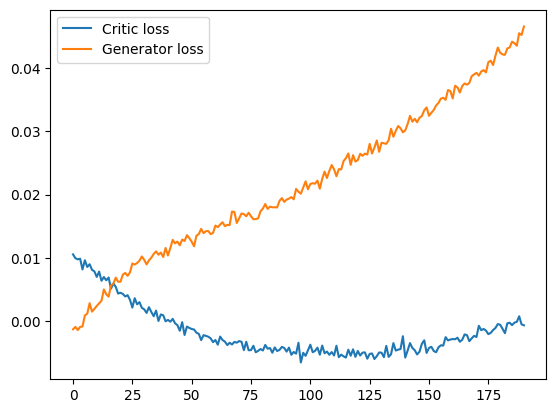

iteration: 201      critic: 0.001227      gen 0.045708
iteration: 211      critic: 0.000916      gen 0.049559
iteration: 221      critic: 0.000467      gen 0.054106
iteration: 231      critic: 0.002496      gen 0.059741
iteration: 241      critic: 0.001828      gen 0.065637
iteration: 251      critic: 0.003352      gen 0.072761
iteration: 261      critic: 0.002531      gen 0.082519
iteration: 271      critic: 0.002892      gen 0.090779
iteration: 281      critic: 0.003063      gen 0.100768
iteration: 291      critic: 0.003963      gen 0.109360
Number iterations: 1
roc: 0.5004   avp: 0.5004   eo: 0.0005
Took 27.407580025990804 minutes so far..
iteration: 301      critic: 0.003112      gen 0.117144
iteration: 311      critic: 0.004514      gen 0.123214
iteration: 321      critic: 0.005321      gen 0.129607
iteration: 331      critic: 0.005199      gen 0.131566
iteration: 341      critic: 0.004947      gen 0.134251
iteration: 351      critic: 0.006592      gen 0.135080
iteration: 361     

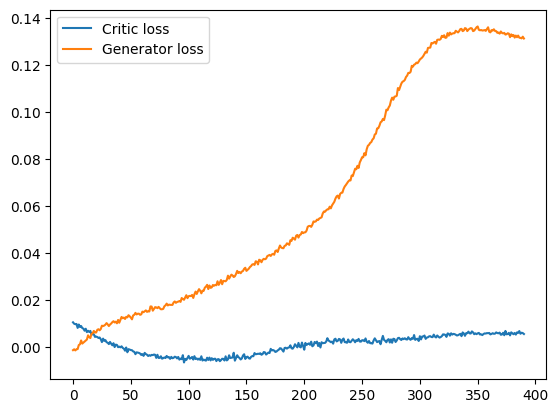

iteration: 401      critic: 0.005977      gen 0.131622
iteration: 411      critic: 0.005364      gen 0.132113
iteration: 421      critic: 0.005768      gen 0.131178
iteration: 431      critic: 0.005874      gen 0.132534
iteration: 441      critic: 0.005224      gen 0.133767
iteration: 451      critic: 0.005673      gen 0.136574
iteration: 461      critic: 0.004788      gen 0.138380
iteration: 471      critic: 0.005174      gen 0.141920
iteration: 481      critic: 0.004178      gen 0.144752
iteration: 491      critic: 0.004612      gen 0.145546
Number iterations: 1
roc: 0.5000   avp: 0.5000   eo: 0.0006
Took 45.68269979953766 minutes so far..
iteration: 501      critic: 0.004478      gen 0.146752
iteration: 511      critic: 0.004844      gen 0.147794
iteration: 521      critic: 0.004261      gen 0.148608
iteration: 531      critic: 0.004252      gen 0.149251
iteration: 541      critic: 0.004093      gen 0.150916
iteration: 551      critic: 0.004948      gen 0.152169
iteration: 561      

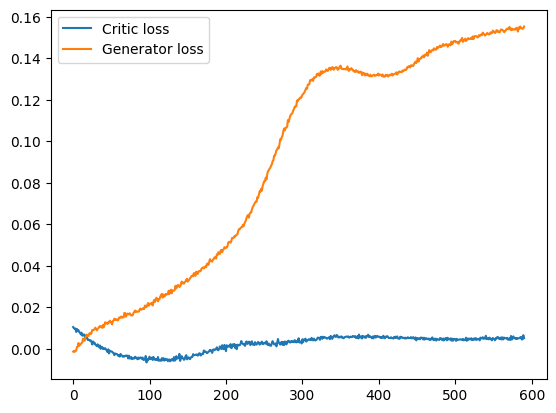

In [ ]:
trainer.train(
create_graph_every=100, # Generate graph by evaluating every 2000 steps
plot_graph_every=200, # plot the loss curve every 500 steps
num_samples_graph=1000, # number of walks to generate when evaluating
stopping_criterion='val', # early termination mode
max_patience=5
)


In [ ]:
# Save the parameters of the generator and discriminator
torch.save(trainer.generator.state_dict(), 'generator.pth')
torch.save(trainer.discriminator.state_dict(), 'discriminator.pth')
